In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from collections import Counter
import math
import matplotlib.pyplot as plt
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
stopwords = ['lmao', 'fuck', 'fucking', 'f', 'op', 'hahahaha', 'hahahahahaha', 'loooooool', 'bro', 'fuuuck', 'im', 'lmfao', 'brb', 'pennsimp26', 'doctordick8', 'residentsleeper']


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import json, requests, matplotlib as mpl
from cycler import cycler
sharing_link = "https://drive.google.com/file/d/1-9ohAAadugbNcn9nkzrqxZ8IOja5thxf/view?usp=sharing"
config_link = 'https://drive.google.com/uc?id=1-9ohAAadugbNcn9nkzrqxZ8IOja5thxf'
res = requests.get(config_link)
if res.ok:
  custom_config = json.loads(res.text)
else:
  err_str = f"Could not read config file from drive link! Received {res.status_code} : {res.reason}\n{res.text}"
  raise ConnectionError(err_str)

custom_config['axes.prop_cycle'] = cycler(color=custom_config['cycle_cols'])
custom_config
del(custom_config['cycle_cols'])
mpl.rcParams.update(**custom_config)
custom_config

{'lines.linewidth': 4,
 'lines.linestyle': '--',
 'axes.labelcolor': '#000000',
 'axes.titlecolor': '#000000',
 'axes.labelsize': 12,
 'axes.titlesize': 16,
 'figure.figsize': [10, 5],
 'grid.color': '#AAAAAA',
 'xtick.color': '#000000',
 'ytick.color': '#000000',
 'axes.edgecolor': '#000000',
 'axes.prop_cycle': cycler('color', ['#A149FA', '#3B44F6', '#3EC70B', '#F7EC09'])}

In [ ]:
# Creates a df containing the combined text of a post with all of its attached comments
submissions_df = pd.read_csv('/content/drive/MyDrive/CIS 5450/submissions_cleaned.csv')
submissions_df['weight'] = submissions_df.groupby(['id'])['score'].transform('sum')
submissions_df['text'] = submissions_df.groupby(['id'])['text'].transform(lambda x: ' '.join(x))
submissions_df = submissions_df[['id', 'subreddit_name', 'text', 'weight', 'url']].drop_duplicates(subset=['id', 'subreddit_name', 'text'])
submissions_df

,id,subreddit_name,text,weight,url
0,1,upenn,nearly every woman know sexually assaulted ca...,133,/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...
17,2,upenn,much overkill common sense haha thanks reall...,328,/r/UPenn/comments/i0px8j/having_guests_in_your...
69,3,upenn,take 240k loan invest stock market though sm...,343,/r/UPenn/comments/u40kjp/dont_come_to_penn_to_...
94,4,upenn,removed comment account young please contact ...,114,/r/UPenn/comments/gpsj3t/nyu_columbia_will_be_...
104,5,upenn,found thread interesting well researched tldr...,60,/r/UPenn/comments/yy57vp/elon_musk_misrepresen...
...,...,...,...,...,...
381560,57689,gatech,try pearson app possible could try another ...,7,/r/gatech/comments/x7c1kh/i_need_some_serious_...
381563,57691,gatech,monitors throughout building huge bank third ...,15,/r/gatech/comments/x709ux/is_there_a_room_with...
381570,57692,gatech,source trust bro proof taken bs rushing ifc r...,390,/r/gatech/comments/x6zrld/wet_weekend_greek_li...
381585,57693,gatech,except first half 3 wins school like piss poor...,795,/r/gatech/comments/x6zcj0/yall_gotta_fire_yall...


In [ ]:
# Adding a column to dataframe containing all nouns from post text using nltk pos tagging
text_subjects = []
for i in submissions_df.index:
  text = submissions_df['text'][i].split()
  pos_tagged_text = nltk.pos_tag(text)
  nouns = []
  for word, pos in pos_tagged_text: 
    if pos == 'NN':
      nouns.append(word)
  nouns = ' '.join(nouns)
  text_subjects.append(nouns)

submissions_df['text_subjects'] = text_subjects

In [ ]:
# List of schools' subreddits that we are analyzing
schools = list(submissions_df['subreddit_name'].unique())
schools

['upenn',
 'princeton',
 'mit',
 'harvard',
 'stanford',
 'yale',
 'uchicago',
 'caltech',
 'brownu',
 'columbia',
 'cornell',
 'dartmouth',
 'cmu',
 'uiuc',
 'berkeley',
 'gatech']

In [ ]:
# Method to calculate document frequency for a subreddit
def calculate_doc_freq(subreddit_name):
  subreddit_submissions = submissions_df[submissions_df['subreddit_name'] == subreddit_name][['subreddit_name', 'text_subjects']]
  doc_freq = {}
  for i in subreddit_submissions.index:
    text = str(subreddit_submissions['text_subjects'][i]).split()
    for word in text: 
      if word in doc_freq: 
        doc_freq[word].add(i)
      else: 
        doc_freq[word] = {i}

  for key in doc_freq: 
    doc_freq[key] = len(doc_freq[key])

  return doc_freq

In [ ]:
df = calculate_doc_freq('upenn')
len(sorted(df.items(), key=lambda x: x[1], reverse=True))

10957

In [ ]:
# Method to calculate term frequency for a subreddit
def calculate_tf(subreddit_name):
  subreddit_submissions = submissions_df[submissions_df['subreddit_name'] == subreddit_name][['subreddit_name', 'text_subjects', 'id']]
  tf = {}
  for i in subreddit_submissions.index:
    text = str(subreddit_submissions['text_subjects'][i]).split()
    for word in text: 
      if word in tf: 
        tf[word] += 1
      else: 
        tf[word] = 1
  return tf

In [ ]:
# Method to calculate tf-idf values for a subreddit
def calculate_tf_idf(subreddit_name):
  subreddit_submissions = submissions_df[submissions_df['subreddit_name'] == subreddit_name][['subreddit_name', 'text_subjects', 'id', 'weight']]
  num_submissions = subreddit_submissions.shape[0]
  tf_idf = {}
  doc_freq = calculate_doc_freq(subreddit_name)
  for i in subreddit_submissions.index:
    text = str(subreddit_submissions['text_subjects'][i]).split()
    id = subreddit_submissions['id'][i]
    weight = subreddit_submissions['weight'][i]
    counter = Counter(text)
    if len(text) < 5:
      continue
    for word in set(text):
      if word in stopwords or len(word) <= 2: 
        continue
      tf = counter[word] / len(text)
      df = doc_freq[word]
      idf = math.log(num_submissions / df)
      tf_idf[(word, id)] = tf * idf * weight
  return tf_idf

In [ ]:
# Getting a list of top 20 words with highest tf-idf values from upenn subreddit
tf_idf = calculate_tf_idf('upenn')
tf_idf = sorted(tf_idf.items(), key=lambda x: x[1], reverse=True)
tf_idf = tf_idf[:20]
tf_idf

[(('drinker', 2005), 492.2910215906962),
 (('union', 1046), 459.39179209258026),
 (('haverford', 290), 431.43475352993283),
 (('spit', 2005), 429.9832518232536),
 (('tater', 2044), 343.2704735528552),
 (('hurrah', 2196), 325.22393281557305),
 (('pennis', 1965), 316.77017532610085),
 (('pennsimp26', 2002), 315.9867209280309),
 (('accent', 2281), 310.9626642772924),
 (('tube', 2095), 303.00603427161525),
 (('toast', 2171), 279.07749171742626),
 (('racism', 712), 271.9638705793935),
 (('pride', 1965), 260.9644088553176),
 (('mcds', 2730), 260.19324970140786),
 (('stadium', 2018), 259.77294391896595),
 (('marriage', 2045), 251.8451776191471),
 (('mooooon', 1974), 251.20283253692836),
 (('heavy', 2726), 248.9653984009719),
 (('jeopardy', 2726), 248.9653984009719),
 (('break', 2052), 242.9198704565574)]

In [ ]:
submissions_df[submissions_df['id'] == 1]

,id,subreddit_name,text,weight,url,text_subjects
0,1,upenn,nearly every woman know sexually assaulted ca...,133,/r/UPenn/comments/r94f1p/tw_rape_we_have_a_hug...,woman cause culture frat hs alcohol vulnerabil...


[('drinker', 2005), ('union', 1046), ('haverford', 290), ('spit', 2005), ('tater', 2044), ('hurrah', 2196), ('pennis', 1965), ('accent', 2281), ('tube', 2095), ('toast', 2171), ('racism', 712), ('pride', 1965), ('mcds', 2730), ('stadium', 2018), ('marriage', 2045), ('mooooon', 1974), ('heavy', 2726), ('jeopardy', 2726), ('break', 2052), ('riddance', 2730)]
[('grass', 3940), ('kidney', 5721), ('racism', 5785), ('gracepoint', 5003), ('spoon', 5949), ('vowel', 4010), ('math', 4570), ('egg', 5693), ('halo', 5949), ('search', 4993), ('danger', 6548), ('sunlight', 6548), ('pizza', 5221), ('leader', 4299), ('cat', 5845), ('discrimination', 5785), ('ethernet', 6172), ('bent', 5949), ('algs', 4304), ('beforehand', 5721)]
[('elitism', 9916), ('enclosure', 10005), ('vertex', 7785), ('massie', 9469), ('coffee', 9460), ('insta', 9206), ('congress', 9469), ('pan', 9516), ('vlad', 7708), ('beacon', 9322), ('shirt', 9701), ('onion', 9811), ('zion', 9516), ('smell', 9470), ('penis', 9807), ('administra

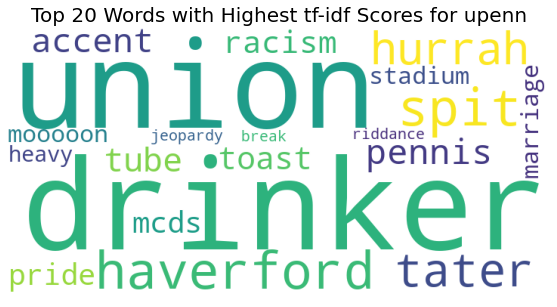

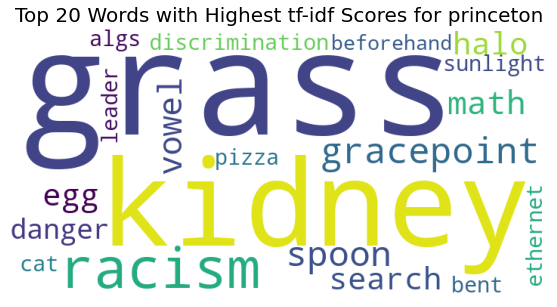

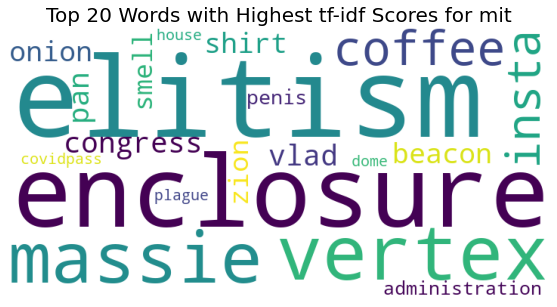

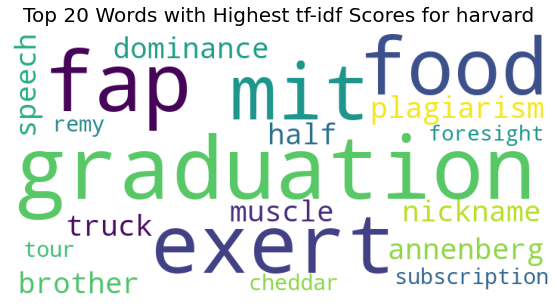

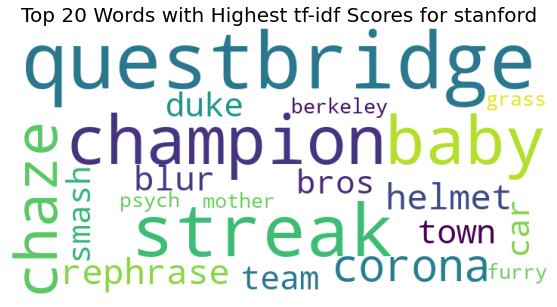

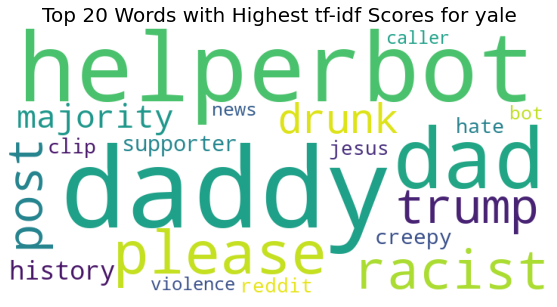

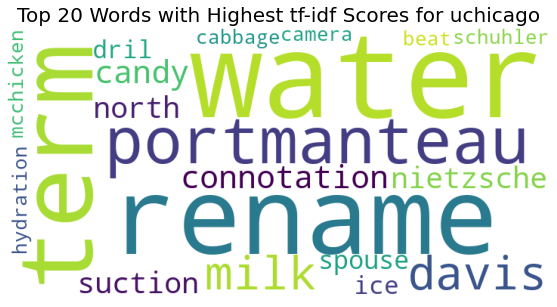

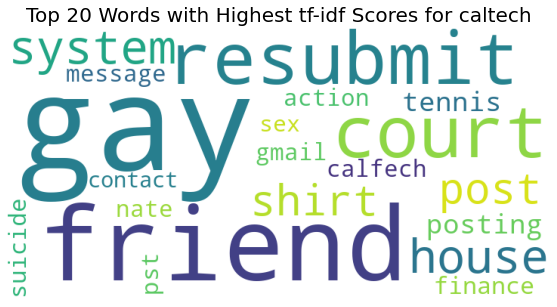

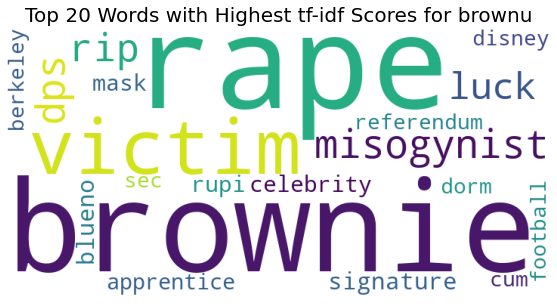

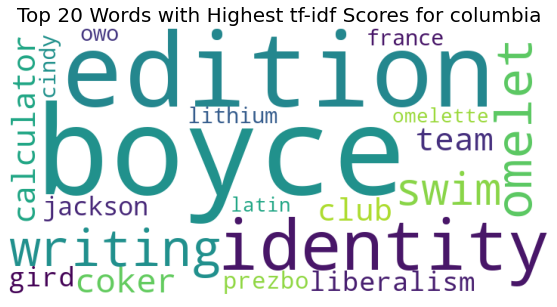

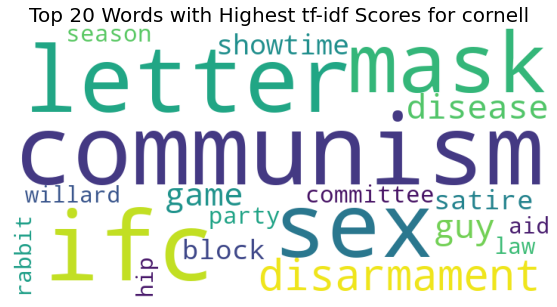

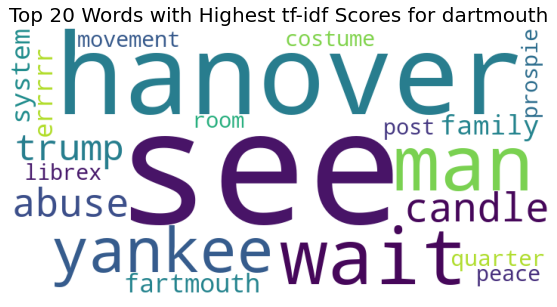

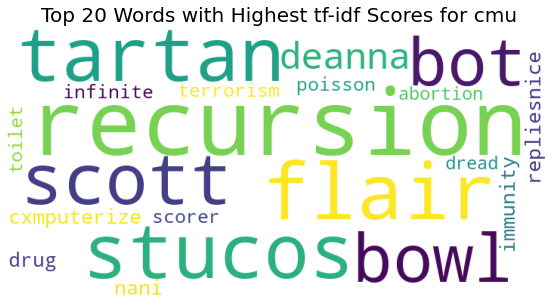

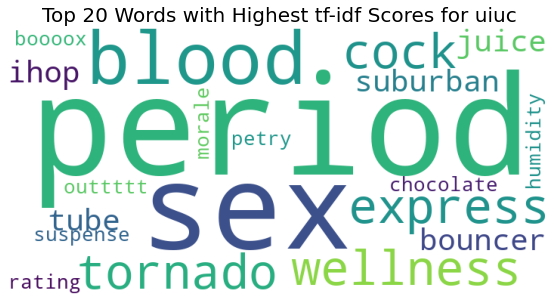

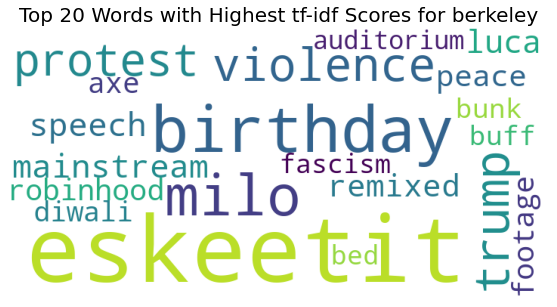

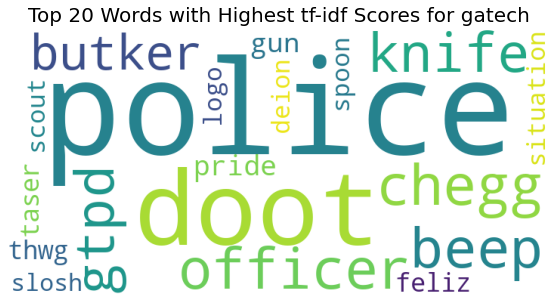

In [ ]:
from wordcloud import WordCloud

# Create a wordcloud using top 20 words with highest tf-idf values for each subreddit
for school in schools: 
  tf_idf = calculate_tf_idf(school)
  sorted_tf_idf = sorted(tf_idf.items(), key=lambda x: x[1], reverse=True)
  top_20_tf_idf = sorted_tf_idf[:20]
  print([x for x, y in top_20_tf_idf])
  word_vals = {x[0] : y for x, y in top_20_tf_idf}
  fig, ax = plt.subplots()
  px = 1/plt.rcParams['figure.dpi']
  # fig.set_size_inches((20, 12))
  wordcloud = WordCloud(width=int(fig.get_size_inches()[0] / px), height=int(fig.get_size_inches()[1] / px), background_color='white', min_font_size=10).generate_from_frequencies(frequencies=word_vals)
  
  ax.set_title(f'Top 20 Words with Highest tf-idf Scores for {school}', fontsize=20)
  ax.axis('off')
  ax.imshow(wordcloud)
  fig.show()
  svg_path = f'/content/drive/MyDrive/CIS 5450/School Happenings/{school}_tf_idf.svg'
  fig.savefig(svg_path)
